In [3]:
import os
rutaBase = os.getcwd().replace('\\', '/') + '/'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set(context='notebook')

In [5]:
from calendar import monthrange
from simpledbf import Dbf5

## Funciones

In [6]:
def mediaMensual(serieD, thr=.8):
    
    daysMonth = serieD.resample('M').count()
    serieM = serieD.resample('M').sum()

    for month in daysMonth.index:
        y, m = month.year, month.month
        ndays = monthrange(y, m)[1]
        mask = daysMonth.loc[month] > .8 * ndays
        serieM.loc[month, mask] *= ndays / daysMonth.loc[month, mask]
        serieM.loc[month, ~mask] = np.nan
    serieM = serieM.round(decimals=1)
    
    return serieM

In [7]:
def plotSerieMensual(serieM, stnsCuenca, **kwargs):
    
    nrows = len(list(stnsCuenca.keys()))

    fig, ax = plt.subplots(nrows=nrows, figsize=(15, 3  * nrows))

    for i, cuenca in enumerate(stnsCuenca):
        for stn in stnsCuenca[cuenca]:
            try:
                ax[i].plot(serieM[stn], lw=1, label=stn)
            except:
                continue
        ax[i].set_title(cuenca)
        if 'xlim' in kwargs:
            ax[i].set_xlim(kwargs['xlim'])
        if 'ylim' in kwargs:
            ax[i].set_ylim(kwargs['ylim'])
        ax[i].legend();

## Datos AEMET

In [8]:
stnsCuencaAEMET = {'Deva': ['1167C', '1172U', '1174I', '1176'],
              'Nansa': ['1159O', '1160E', '1160I', '1161I', '1165E', '1156'],
              'Saja-Besaya': ['1140', '1144', '1151', '1131I', '1139E', '1136A'],
              'Pas': ['1117B', '1120', '1122I', '1124', '1127U', '1128', '1127', '1129', '1115'],
              'Miera': ['1104', '1104O', '1109', '1110'],
              'Ason': ['1093', '1095E', '1097', '1086']}

In [9]:
rutaOneDrive = 'F:/OneDrive - Universidad de Cantabria/'
rutaAEMET = rutaOneDrive + 'Series/AEMET/2016_pet080_UNICAN/data/Precipitacion/'
# rutaAEMET = 'G:/CLIMA/02_HYDRO-CLIMATE/AEMET/precipitacion/diario/'

In [10]:
stnAEMET = pd.read_csv(rutaAEMET + 'Estaciones_pcp.csv', encoding='latin1', index_col='INDICATIVO')

In [11]:
#stnAEMET = stnAEMET.loc[stnAEMET.NOM_PROV == 'CANTABRIA', :]
stns = [stn for c in stnsCuencaAEMET for stn in stnsCuencaAEMET[c]]
stnAEMET = stnAEMET.loc[stns, :]
len(stns), stnAEMET.shape

(33, (33, 7))

In [12]:
st, en = pd.datetime(2000, 1, 1).date(), pd.datetime(2015, 12, 31).date()

In [13]:
pdAEMET = pd.read_csv(rutaAEMET + 'pcp_1950.csv', parse_dates=True, index_col='fecha')
pdAEMET = pdAEMET.loc[st:en, stnAEMET.index]
pdAEMET[pdAEMET == -3] = 0
pdAEMET[pdAEMET == -4] = np.nan
pdAEMET /= 10
pdAEMET.dropna(axis=1, how='all', inplace=True)

pdAEMET.shape

(5844, 17)

In [14]:
pmAEMET = mediaMensual(pdAEMET)

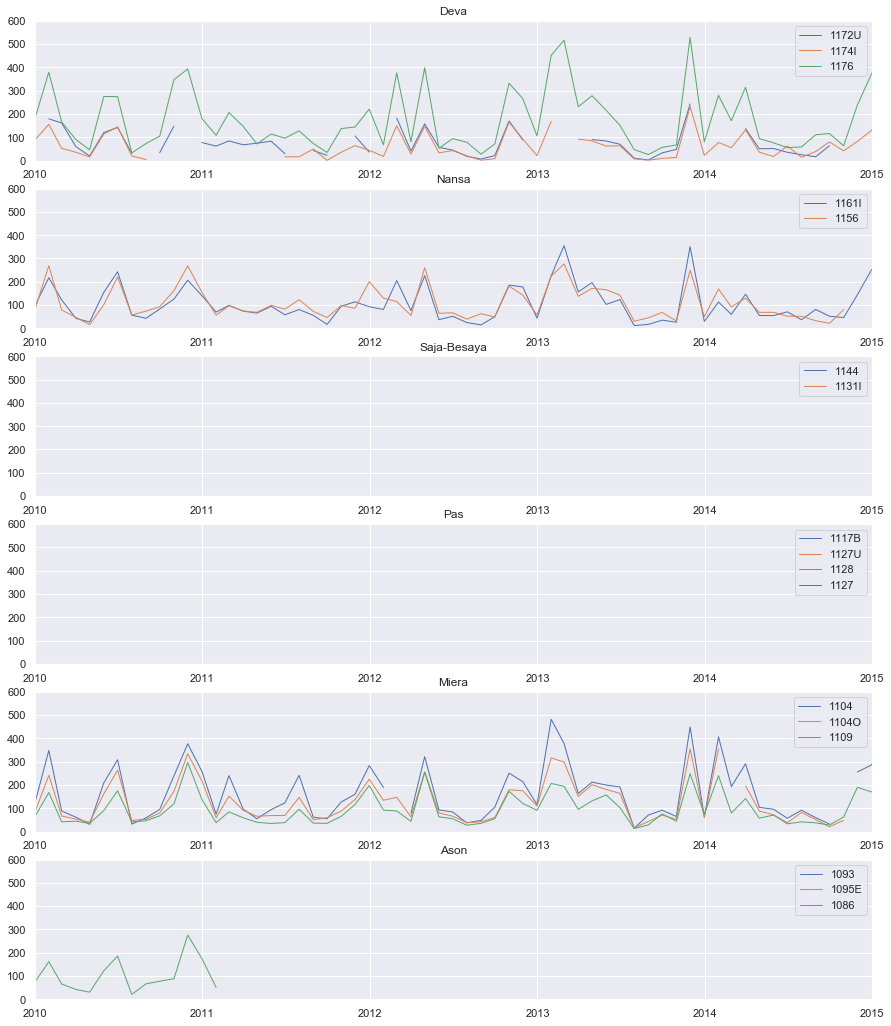

In [15]:
plotSerieMensual(pmAEMET, stnsCuencaAEMET, xlim=('2010', '2015'), ylim=(0, 600))

## DATOS SAIH

In [16]:
rutaSAIH = 'G:/CLIMA/02_HYDRO-CLIMATE/CHC/SAI/'

In [17]:
stnsCuencaSAIH = {'Deva': ['A078', 'A702'],
                  'Nansa': ['A252', 'N078'],
                  'Saja-Besaya': ['E055', 'A707', 'A708', 'Q119', 'P071'],
                  'Pas': ['Q104', 'A705'],
                  'Miera': ['Q118', 'A091', 'N045'],
                  'Ason': ['A701', 'A141', 'A143', 'P070', 'A706']}

In [18]:
stns = [stn for c in stnsCuencaSAIH for stn in stnsCuencaSAIH[c]]
len(stns)

19

In [19]:
pdSAIH = pd.DataFrame(index=pd.date_range(st, en))
cols = []
for stn in stns:
    cols.append(stn)
    aux = pd.read_csv(rutaSAIH + 'tratadas/1D/' + stn + '.csv', encoding='latin1', parse_dates=True, index_col=0)
    aux = aux['precipitacion_mm']
    pdSAIH = pd.concat((pdSAIH, aux), axis=1)
    pdSAIH.columns = cols
    
pdSAIH = pdSAIH.loc[pdSAIH.first_valid_index():pdSAIH.last_valid_index(), :]

pdSAIH.shape

(3868, 19)

In [20]:
stnsSAIH = Dbf5(rutaSAIH + 'GIS/Estaciones_SAIH-CHC.dbf', codec='latin-1').to_dataframe()
stnsSAIH.set_index('COD_SAIH', drop=True, inplace=True)
stnsSAIH = stnsSAIH.loc[stns,:]
stnsSAIH.COD_ROEA = stnsSAIH.COD_ROEA.astype(int).astype(str)
stnsSAIH['CUENCA'] = np.nan
for c in stnsCuencaSAIH:
    stnsSAIH.loc[stnsCuencaSAIH[c], 'CUENCA'] = c
stnsSAIH.columns = ['COD_ROEA', 'RED', 'SISTEMA', 'RIO', 'UBICACION', 'MUNICIPIO',
                    'PROVINCIA', 'X_ETRS89_UTM', 'Y_ETRS89_UTM', 'precip', 'caudal', 'nivel',
                    'Taire', 'amonio', 'conduct', 'oxigeno', 'pH', 'Tagua', 'turbidez',
                    'inicio', 'fin', 'CUENCA']
stnsSAIH = stnsSAIH[['COD_ROEA', 'RED', 'SISTEMA', 'CUENCA', 'RIO', 'UBICACION', 'MUNICIPIO',
                    'PROVINCIA', 'X_ETRS89_UTM', 'Y_ETRS89_UTM', 'precip', 'caudal', 'nivel',
                    'Taire', 'amonio', 'conduct', 'oxigeno', 'pH', 'Tagua', 'turbidez',
                    'inicio', 'fin']]
stnsSAIH.head()

COD_ROEA  RED     SISTEMA       CUENCA      RIO  \
COD_SAIH                                                   
A078         1268  CHC        Deva         Deva     Deva   
A702         1264  CHC        Deva         Deva  BullÃ³n   
A252         1252  CHC       Nansa        Nansa    Nansa   
N078         1262  CHC  Gandarilla        Nansa   Escudo   
E055         1242  CHC        Saja  Saja-Besaya     Saja   

                                           UBICACION              MUNICIPIO  \
COD_SAIH                                                                      
A078                          Rio Deva en Puentelles      PeÃ±amellera Baja   
A702                             Rio Bullon en Ojedo  Cillorigo de LiÃ©bana   
A252                      RÃ­o Nansa en Puente Pumar             Polaciones   
N078                RÃ­o Escudo en Roiz (Las Cuevas)             ValdÃ¡liga   
E055      RÃ­o Saja en el Azud del Puente San Miguel            Torrelavega   

          PROVINCIA   X_ETRS89_UTM  Y_ETRS89_UTM  ...  nivel  Taire  amonio  \
COD_SAIH                                          ...                         
A078       Asturias  369676.695874  4.797288e+06  ...      1      1       0   
A702      Cantabria  368977.608766  4.780031e+06  ...      1      1       0   
A252      Cantabria  385689.000000  4.774352e+06  ...      1      1       0   
N078      Cantabria  390470.522518  4.798222e+06  ...      1      1       0   
E055      Cantabria  412801.131971  4.801214e+06  ...      1      1       0   

          conduct  oxigeno  pH  Tagua  turbidez      inicio         fin  
COD_SAIH                                                                 
A078            0        0   0      0         0  2008-10-28  2019-05-31  
A702            0        0   0      0         0  2010-03-24  2019-05-31  
A252            0        0   0      0         0  2014-07-18  2019-05-31  
N078            0        0   0      0         0  2011-11-03  2019-05-31  
E055            0        0   0      0         0  2011-10-21  2019-05-31  

[5 rows x 22 columns]

In [21]:
pmSAIH = mediaMensual(pdSAIH)

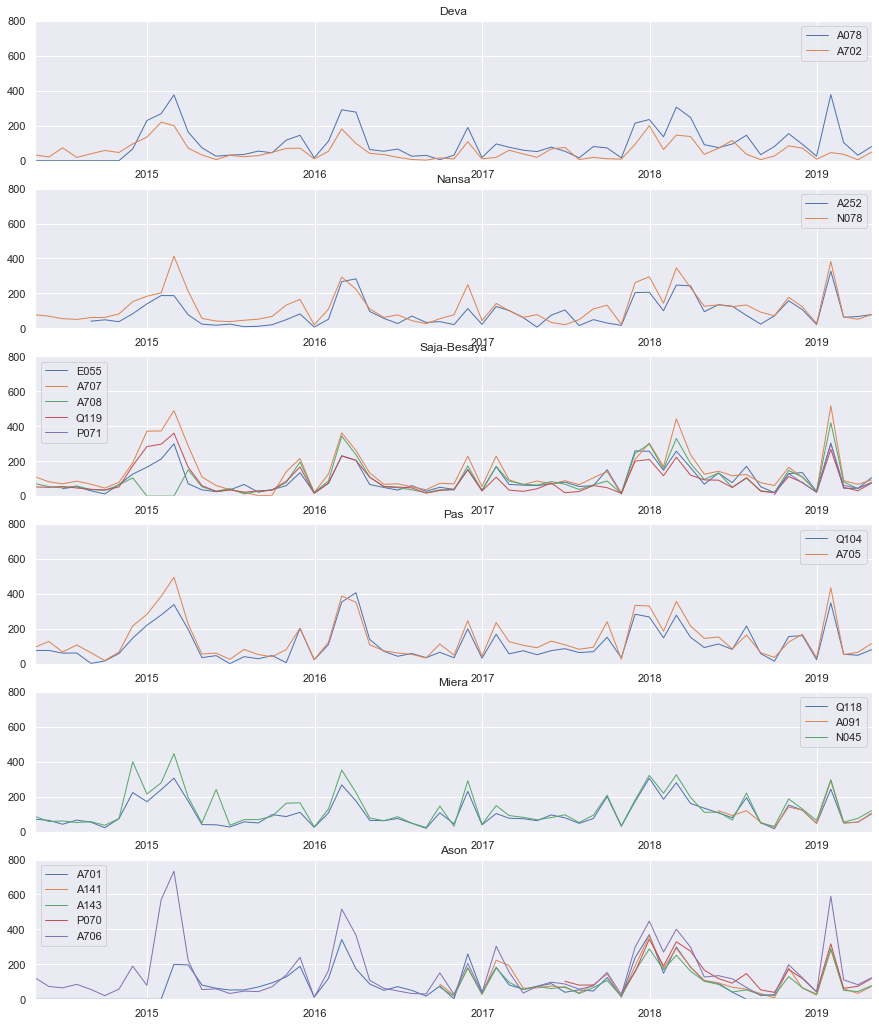

In [22]:
plotSerieMensual(pmSAIH, stnsCuencaSAIH, xlim=('2014-5', '2019-5'), ylim=(0, 800))

In [23]:
selStns = ['A078', 'N078', 'E055', 'A707', 'Q119', 'Q104', 'A705', 'Q118', 'N045', 'A706']

In [24]:
pmSAIH_ = pmSAIH.loc['2014-6':'2019-5', selStns]
pmSAIH_.loc['2014-6':'2014-10', 'A078'] = np.nan
pmSAIH_.index.name = 'fecha'
pmSAIH_.shape

(60, 10)

In [25]:
pmSAIH_.to_csv(rutaBase + '../output/Precipitación mensual 2014-2019.csv', float_format='%.1f')

In [26]:
stnsSAIH_ = stnsSAIH.loc[selStns, :]
stnsSAIH_.shape

(10, 22)

In [27]:
stnsSAIH_.to_csv(rutaBase + '../output/Estaciones SAIH-CHC.csv', float_format='%.1f')